In [2]:
pip install torch torchvision numpy matplotlib scikit-image

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 533.4 kB/s eta 0:00:0000:0100:04
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 833.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 449.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [4]:

# Device configuration for Mac M1 (Metal Performance Shaders - MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
def get_svhn_loaders(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)
    test_dataset = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, test_loader

train_loader, test_loader = get_svhn_loaders()


In [8]:

# Define CNN Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, sparse=False):
        super(Autoencoder, self).__init__()
        self.sparse = sparse
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [9]:

# Training Function
def train_autoencoder(model, train_loader, optimizer, criterion, epochs=100, sparse=False, clip_range=(-0.5,0.5)):
    model.to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # L1 sparsity constraint
            if sparse:
                l1_lambda = 1e-5  # Regularization strength
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
            
            loss.backward()
            optimizer.step()
            
            # Weight Clipping
            for p in model.parameters():
                p.data.clamp_(clip_range[0], clip_range[1])
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}")
    
    return model


In [10]:

# PSNR Calculation
def evaluate_psnr(model, test_loader):
    model.eval()
    total_psnr = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            images = images.cpu().numpy()
            outputs = outputs.cpu().numpy()
            
            batch_psnr = np.mean([psnr(images[i], outputs[i]) for i in range(len(images))])
            total_psnr += batch_psnr
    
    return total_psnr / len(test_loader)


In [11]:

# Train Autoencoders
mse_autoencoder = Autoencoder(sparse=False).to(device)
mse_sparse_autoencoder = Autoencoder(sparse=True).to(device)

# Optimizers
optimizer_mse = optim.Adam(mse_autoencoder.parameters(), lr=1e-3)
optimizer_sparse = optim.Adam(mse_sparse_autoencoder.parameters(), lr=1e-3)

# Loss function
criterion = nn.MSELoss()


In [12]:

print("Training Autoencoder with MSE Loss")
mse_autoencoder = train_autoencoder(mse_autoencoder, train_loader, optimizer_mse, criterion, epochs=100, sparse=False)


Training Autoencoder with MSE Loss
Epoch [1/100], Loss: 0.003825
Epoch [2/100], Loss: 0.000841
Epoch [3/100], Loss: 0.000543
Epoch [4/100], Loss: 0.000422
Epoch [5/100], Loss: 0.000369
Epoch [6/100], Loss: 0.000322
Epoch [7/100], Loss: 0.000273
Epoch [8/100], Loss: 0.000243
Epoch [9/100], Loss: 0.000233
Epoch [10/100], Loss: 0.000210
Epoch [11/100], Loss: 0.000193
Epoch [12/100], Loss: 0.000184
Epoch [13/100], Loss: 0.000168
Epoch [14/100], Loss: 0.000160
Epoch [15/100], Loss: 0.000152
Epoch [16/100], Loss: 0.000145
Epoch [17/100], Loss: 0.000138
Epoch [18/100], Loss: 0.000131
Epoch [19/100], Loss: 0.000123
Epoch [20/100], Loss: 0.000118
Epoch [21/100], Loss: 0.000115
Epoch [22/100], Loss: 0.000107
Epoch [23/100], Loss: 0.000106
Epoch [24/100], Loss: 0.000101
Epoch [25/100], Loss: 0.000097
Epoch [26/100], Loss: 0.000092
Epoch [27/100], Loss: 0.000089
Epoch [28/100], Loss: 0.000086
Epoch [29/100], Loss: 0.000088
Epoch [30/100], Loss: 0.000080
Epoch [31/100], Loss: 0.000081
Epoch [32/100

In [13]:
print("Training Autoencoder with MSE + L1 Regularization")
mse_sparse_autoencoder = train_autoencoder(mse_sparse_autoencoder, train_loader, optimizer_sparse, criterion, epochs=100, sparse=True)


Training Autoencoder with MSE + L1 Regularization
Epoch [1/100], Loss: 0.044079
Epoch [2/100], Loss: 0.040569
Epoch [3/100], Loss: 0.040511
Epoch [4/100], Loss: 0.040478
Epoch [5/100], Loss: 0.040466
Epoch [6/100], Loss: 0.040449
Epoch [7/100], Loss: 0.040433
Epoch [8/100], Loss: 0.040438
Epoch [9/100], Loss: 0.040414
Epoch [10/100], Loss: 0.040406
Epoch [11/100], Loss: 0.040419
Epoch [12/100], Loss: 0.040407
Epoch [13/100], Loss: 0.040406
Epoch [14/100], Loss: 0.040412
Epoch [15/100], Loss: 0.040408
Epoch [16/100], Loss: 0.040413
Epoch [17/100], Loss: 0.040413
Epoch [18/100], Loss: 0.040419
Epoch [19/100], Loss: 0.040424
Epoch [20/100], Loss: 0.040406
Epoch [21/100], Loss: 0.040406
Epoch [22/100], Loss: 0.040409
Epoch [23/100], Loss: 0.040407
Epoch [24/100], Loss: 0.040406
Epoch [25/100], Loss: 0.040412
Epoch [26/100], Loss: 0.040411
Epoch [27/100], Loss: 0.040410
Epoch [28/100], Loss: 0.040421
Epoch [29/100], Loss: 0.040409
Epoch [30/100], Loss: 0.040412
Epoch [31/100], Loss: 0.04041

In [14]:

# Evaluate Models
psnr_mse = evaluate_psnr(mse_autoencoder, test_loader)

In [15]:

psnr_sparse = evaluate_psnr(mse_sparse_autoencoder, test_loader)


In [16]:

print(f"PSNR (MSE Autoencoder): {psnr_mse:.2f}")
print(f"PSNR (MSE + L1 Sparse Autoencoder): {psnr_sparse:.2f}")


PSNR (MSE Autoencoder): 46.83
PSNR (MSE + L1 Sparse Autoencoder): 14.30


In [17]:

# Display some reconstructions
def show_images(model, test_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images[:8].to(device)
        outputs = model(images).cpu()
        images = images.cpu()
        
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
            axes[1, i].imshow(np.transpose(outputs[i].numpy(), (1, 2, 0)))
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()


Reconstructed Images: MSE Autoencoder


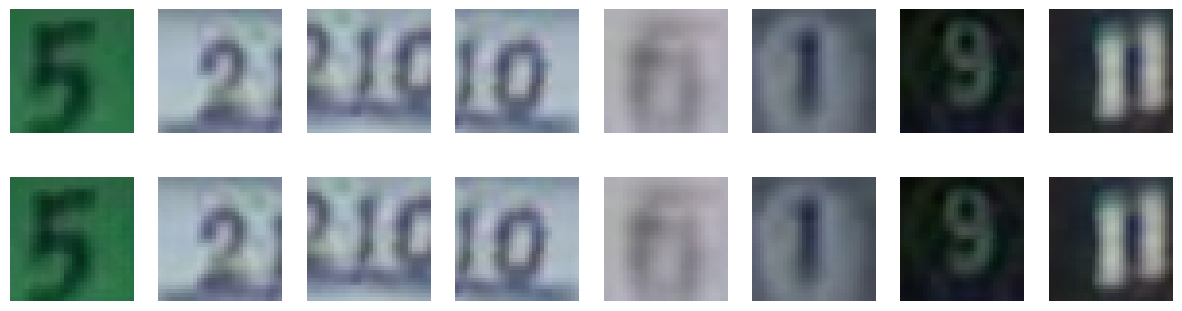

In [18]:

print("Reconstructed Images: MSE Autoencoder")
show_images(mse_autoencoder, test_loader)

Reconstructed Images: MSE + L1 Sparse Autoencoder


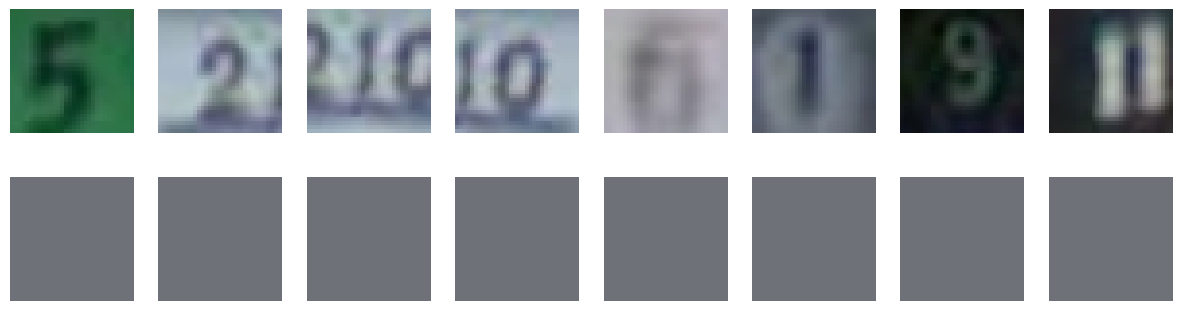

In [19]:

print("Reconstructed Images: MSE + L1 Sparse Autoencoder")
show_images(mse_sparse_autoencoder, test_loader)

Training with lr=0.001, clip_range=(-0.5, 0.5), sparse=False
Epoch [1/50], Loss: 0.004010
Epoch [2/50], Loss: 0.000902
Epoch [3/50], Loss: 0.000578
Epoch [4/50], Loss: 0.000452
Epoch [5/50], Loss: 0.000381
Epoch [6/50], Loss: 0.000324
Epoch [7/50], Loss: 0.000286
Epoch [8/50], Loss: 0.000258
Epoch [9/50], Loss: 0.000253
Epoch [10/50], Loss: 0.000215
Epoch [11/50], Loss: 0.000203
Epoch [12/50], Loss: 0.000192
Epoch [13/50], Loss: 0.000175
Epoch [14/50], Loss: 0.000169
Epoch [15/50], Loss: 0.000157
Epoch [16/50], Loss: 0.000151
Epoch [17/50], Loss: 0.000141
Epoch [18/50], Loss: 0.000134
Epoch [19/50], Loss: 0.000129
Epoch [20/50], Loss: 0.000125
Epoch [21/50], Loss: 0.000118
Epoch [22/50], Loss: 0.000114
Epoch [23/50], Loss: 0.000108
Epoch [24/50], Loss: 0.000106
Epoch [25/50], Loss: 0.000101
Epoch [26/50], Loss: 0.000096
Epoch [27/50], Loss: 0.000096
Epoch [28/50], Loss: 0.000094
Epoch [29/50], Loss: 0.000092
Epoch [30/50], Loss: 0.000088
Epoch [31/50], Loss: 0.000086
Epoch [32/50], Los

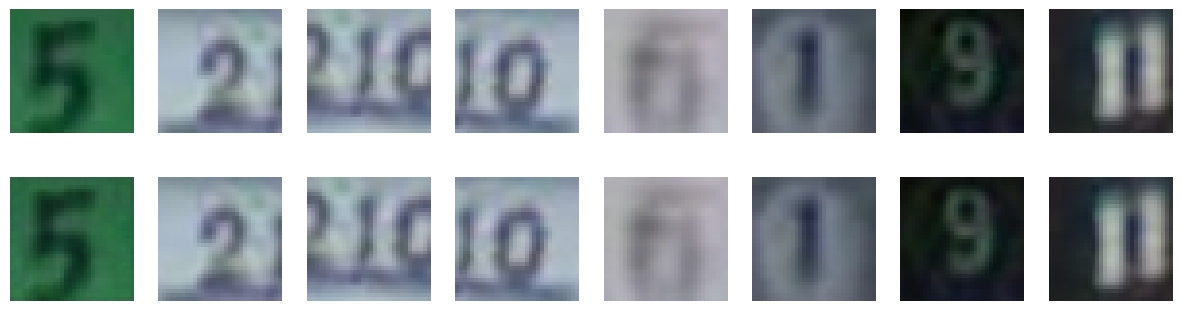

In [20]:
# Hyperparameter Tuning
from itertools import product

learning_rates = [1e-3, 5e-4, 1e-4]
clipping_ranges = [(-0.5, 0.5), (-0.3, 0.3), (-0.1, 0.1)]
epochs = 50 

results = []

def train_and_evaluate_model(lr, clip_range, sparse):
    model = Autoencoder(sparse=sparse).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_autoencoder(model, train_loader, optimizer, criterion, epochs=epochs, sparse=sparse, clip_range=clip_range)
    
    psnr_value = evaluate_psnr(model, test_loader)
    return model, psnr_value

# Perform grid search
for lr, clip_range in product(learning_rates, clipping_ranges):
    print(f"Training with lr={lr}, clip_range={clip_range}, sparse=False")
    model, psnr_value = train_and_evaluate_model(lr, clip_range, sparse=False)
    results.append((model, psnr_value, lr, clip_range, False))

    print(f"Training with lr={lr}, clip_range={clip_range}, sparse=True")
    model, psnr_value = train_and_evaluate_model(lr, clip_range, sparse=True)
    results.append((model, psnr_value, lr, clip_range, True))

best_model, best_psnr, best_lr, best_clip_range, best_sparse = max(results, key=lambda x: x[1])

print(f"Best Model:")
print(f"  PSNR: {best_psnr:.2f}")
print(f"  Learning Rate: {best_lr}")
print(f"  Clipping Range: {best_clip_range}")
print(f"  Sparse: {best_sparse}")

# Show Image Reconstruction for Best Model
def show_best_model_reconstruction():
    print("Reconstructed Images: Best Model")
    show_images(best_model, test_loader)

show_best_model_reconstruction()


Training with optimizer=SGD, activation=ReLU
Epoch [1/50], Loss: 0.040810
Epoch [2/50], Loss: 0.040753
Epoch [3/50], Loss: 0.040679
Epoch [4/50], Loss: 0.040607
Epoch [5/50], Loss: 0.040557
Epoch [6/50], Loss: 0.040506
Epoch [7/50], Loss: 0.040447
Epoch [8/50], Loss: 0.040398
Epoch [9/50], Loss: 0.040354
Epoch [10/50], Loss: 0.040311
Epoch [11/50], Loss: 0.040265
Epoch [12/50], Loss: 0.040229
Epoch [13/50], Loss: 0.040184
Epoch [14/50], Loss: 0.040167
Epoch [15/50], Loss: 0.040122
Epoch [16/50], Loss: 0.040087
Epoch [17/50], Loss: 0.040059
Epoch [18/50], Loss: 0.040029
Epoch [19/50], Loss: 0.040018
Epoch [20/50], Loss: 0.039968
Epoch [21/50], Loss: 0.039946
Epoch [22/50], Loss: 0.039917
Epoch [23/50], Loss: 0.039898
Epoch [24/50], Loss: 0.039883
Epoch [25/50], Loss: 0.039860
Epoch [26/50], Loss: 0.039857
Epoch [27/50], Loss: 0.039828
Epoch [28/50], Loss: 0.039795
Epoch [29/50], Loss: 0.039789
Epoch [30/50], Loss: 0.039776
Epoch [31/50], Loss: 0.039759
Epoch [32/50], Loss: 0.039744
Epoc

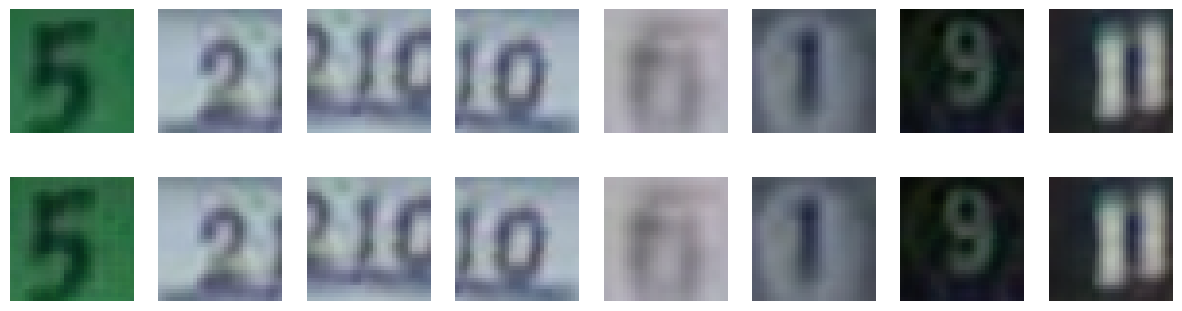

In [21]:
optimizers = ["SGD", "Adam"]
activations = ["ReLU", "LeakyReLU"]
epochs = 50

results = []

def train_and_evaluate_model(optimizer_name, activation_name):
    class Autoencoder(nn.Module):
        def __init__(self, sparse=False):
            super(Autoencoder, self).__init__()
            self.sparse = sparse

            activation = nn.ReLU() if activation_name == "ReLU" else nn.LeakyReLU()

            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                activation,
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                activation,
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                activation
            )

            # Decoder
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                activation,
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                activation,
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid()
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    model = Autoencoder(sparse=False).to(device)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_autoencoder(model, train_loader, optimizer, criterion, epochs=epochs, sparse=False)

    psnr_value = evaluate_psnr(model, test_loader)
    return model, psnr_value

for optimizer_name, activation_name in product(optimizers, activations):
    print(f"Training with optimizer={optimizer_name}, activation={activation_name}")
    model, psnr_value = train_and_evaluate_model(optimizer_name, activation_name)
    results.append((model, psnr_value, optimizer_name, activation_name))

best_model, best_psnr, best_optimizer, best_activation = max(results, key=lambda x: x[1])

print(f"Best Model:")
print(f"  PSNR: {best_psnr:.2f}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Activation Function: {best_activation}")

def show_best_model_reconstruction():
    print("Reconstructed Images: Best Model")
    show_images(best_model, test_loader)

show_best_model_reconstruction()
